# Detection Malware : Random Forest baseline

## Prédiction de forêt aléatoire
### Ce notebook implémente :

Réglage des paramètres de forêt aléatoire avec GridSearchCV
Validation croisée KFold=10 pour généraliser le modèle
Prédiction hors pli sur l'ensemble de données de test, basée sur les meilleures valeurs de départ

In [1]:
# Cet environnement Python 3 est fourni avec de nombreuses bibliothèques d'analyse utiles.

# Par exemple, voici quelques packages utiles à charger :

import numpy as np # algèbre linéaire
import pandas as pd # traitement de données, E/S de fichiers CSV (par exemple, pd.read_csv)
import random
import gc

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier

# Les fichiers de données d'entrée sont disponibles dans le répertoire en lecture seule « ../input/ ».
# Par exemple, l'exécution de cette commande (en cliquant sur Exécuter ou en appuyant sur Maj+Entrée) listera tous les fichiers du répertoire d'entrée.

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
# for filename in filenames:
# print(os.path.join(dirname, filename))

# Vous pouvez écrire jusqu'à 20 Go dans le répertoire courant (/kaggle/working/) et les conserver comme sortie lorsque vous créez une version avec « Enregistrer et exécuter tout ».
# Vous pouvez également écrire des fichiers temporaires dans /kaggle/temp/, mais ils ne seront pas enregistrés en dehors de la session en cours.

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df['Malicious'] = train_df['Malicious'].map({False:0, True:1})
train_df.head(5)

,READ_EXTERNAL_STORAGE,RECEIVE_BOOT_COMPLETED,WRITE_CONTACTS,RECORD_AUDIO,ACCESS_CACHE_FILESYSTEM,RECEIVE,BILLING,READ,ACCESS_LOCATION_EXTRA_COMMANDS,ACCESS_FINE_LOCATION,...,CHANGE_WIFI_STATE,MODIFY_AUDIO_SETTINGS,BLUETOOTH_ADMIN,RECEIVE_SMS,ACCESS_MTK_MMHW,UNINSTALL_SHORTCUT,READ_INTERNAL_STORAGE,ACCESS_COARSE_LOCATION,Malicious,id
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7032
1,0,1,0,0,0,0,0,0,1,0,...,1,1,0,1,0,0,0,0,1,11026
2,0,0,0,0,0,0,0,0,1,1,...,0,1,0,1,0,0,0,1,1,9772
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,844
4,0,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,1,1,14630


In [4]:
TARGET = ['Malicious']
x = train_df.drop(columns=['Malicious'])
y = train_df[TARGET]

In [5]:
# Seed all
seed = 42
random.seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)
np.random.seed(seed)
gc.collect()

0

### Réglage des paramètres avec GridSearchCV

In [6]:
param_grid = {
    'n_estimators': [140],
    'max_depth' : [22]
}
model = RandomForestClassifier(random_state=seed)

CV = GridSearchCV(model,param_grid, cv=10, n_jobs= 1)
                  
CV.fit(x, np.ravel(y))  
print(CV.best_params_)    
print(CV.best_score_)

{'max_depth': 22, 'n_estimators': 140}
0.9720563494793458


### KFOLD=10 Validation croisée avec les meilleures graines

In [7]:
predTest = pd.DataFrame(0, index=np.arange(test_df.shape[0]), columns=TARGET)
predTrain = y[TARGET].copy()

#for seed in random.sample(range(300, 400), 20):
for seed in [15,54,68,79,105,134,189,220,234,281,357,363]:
    FOLDS = 10
    kf = StratifiedKFold(n_splits=FOLDS,shuffle = True, random_state=seed)

    model = RandomForestClassifier(n_estimators=140, max_depth=22, random_state=seed)

    scores = []
        
    fold_num = 0
    for train_index, test_index in kf.split(x,y):
        fold_num += 1
        X_train = x.iloc[train_index]
        y_train = y.iloc[train_index]
        X_val = x.loc[test_index]
        y_val = y.loc[test_index]

        model.fit(X_train,np.ravel(y_train))
        y_pred = model.predict(X_val)
        acc = accuracy_score(y_val,y_pred)
        scores.append(acc)
        print("Fold ",fold_num," Accuracy = ",acc) 

        # OOF prediction
        oof_pred = model.predict(x)
        predTrain.loc[:,"Malicious"] += oof_pred

        # Test prediction
        test_pred = model.predict(test_df)
#        predTest.loc[:,f'{fold_num}_{seed}'] = test_pred
        predTest.loc[:,"Malicious"] += test_pred

    print(f"SEED{seed} CV Accuracy = ",np.mean(scores)," + ",np.std(scores))

Fold  1  Accuracy =  0.9664310954063604
Fold  2  Accuracy =  0.9628975265017667
Fold  3  Accuracy =  0.9770318021201413
Fold  4  Accuracy =  0.9628975265017667
Fold  5  Accuracy =  0.9805309734513274
Fold  6  Accuracy =  0.9769911504424779
Fold  7  Accuracy =  0.9769911504424779
Fold  8  Accuracy =  0.9716814159292035
Fold  9  Accuracy =  0.9734513274336283
Fold  10  Accuracy =  0.984070796460177
SEED15 CV Accuracy =  0.9732974764689327  +  0.006897245642037061
Fold  1  Accuracy =  0.9734982332155477
Fold  2  Accuracy =  0.9770318021201413
Fold  3  Accuracy =  0.9717314487632509
Fold  4  Accuracy =  0.9646643109540636
Fold  5  Accuracy =  0.9699115044247788
Fold  6  Accuracy =  0.9752212389380531
Fold  7  Accuracy =  0.9734513274336283
Fold  8  Accuracy =  0.9734513274336283
Fold  9  Accuracy =  0.9752212389380531
Fold  10  Accuracy =  0.9752212389380531
SEED54 CV Accuracy =  0.9729403671159197  +  0.00335125264726248
Fold  1  Accuracy =  0.9752650176678446
Fold  2  Accuracy =  0.96466

In [8]:
predTest.loc[predTest["Malicious"]<61,'Malicious'] = 0
predTest.loc[predTest["Malicious"]>60,'Malicious'] = 1

In [9]:
predTest['Malicious'].value_counts()

Malicious
0    1215
1    1209
Name: count, dtype: int64

### importance des fonctionnalités

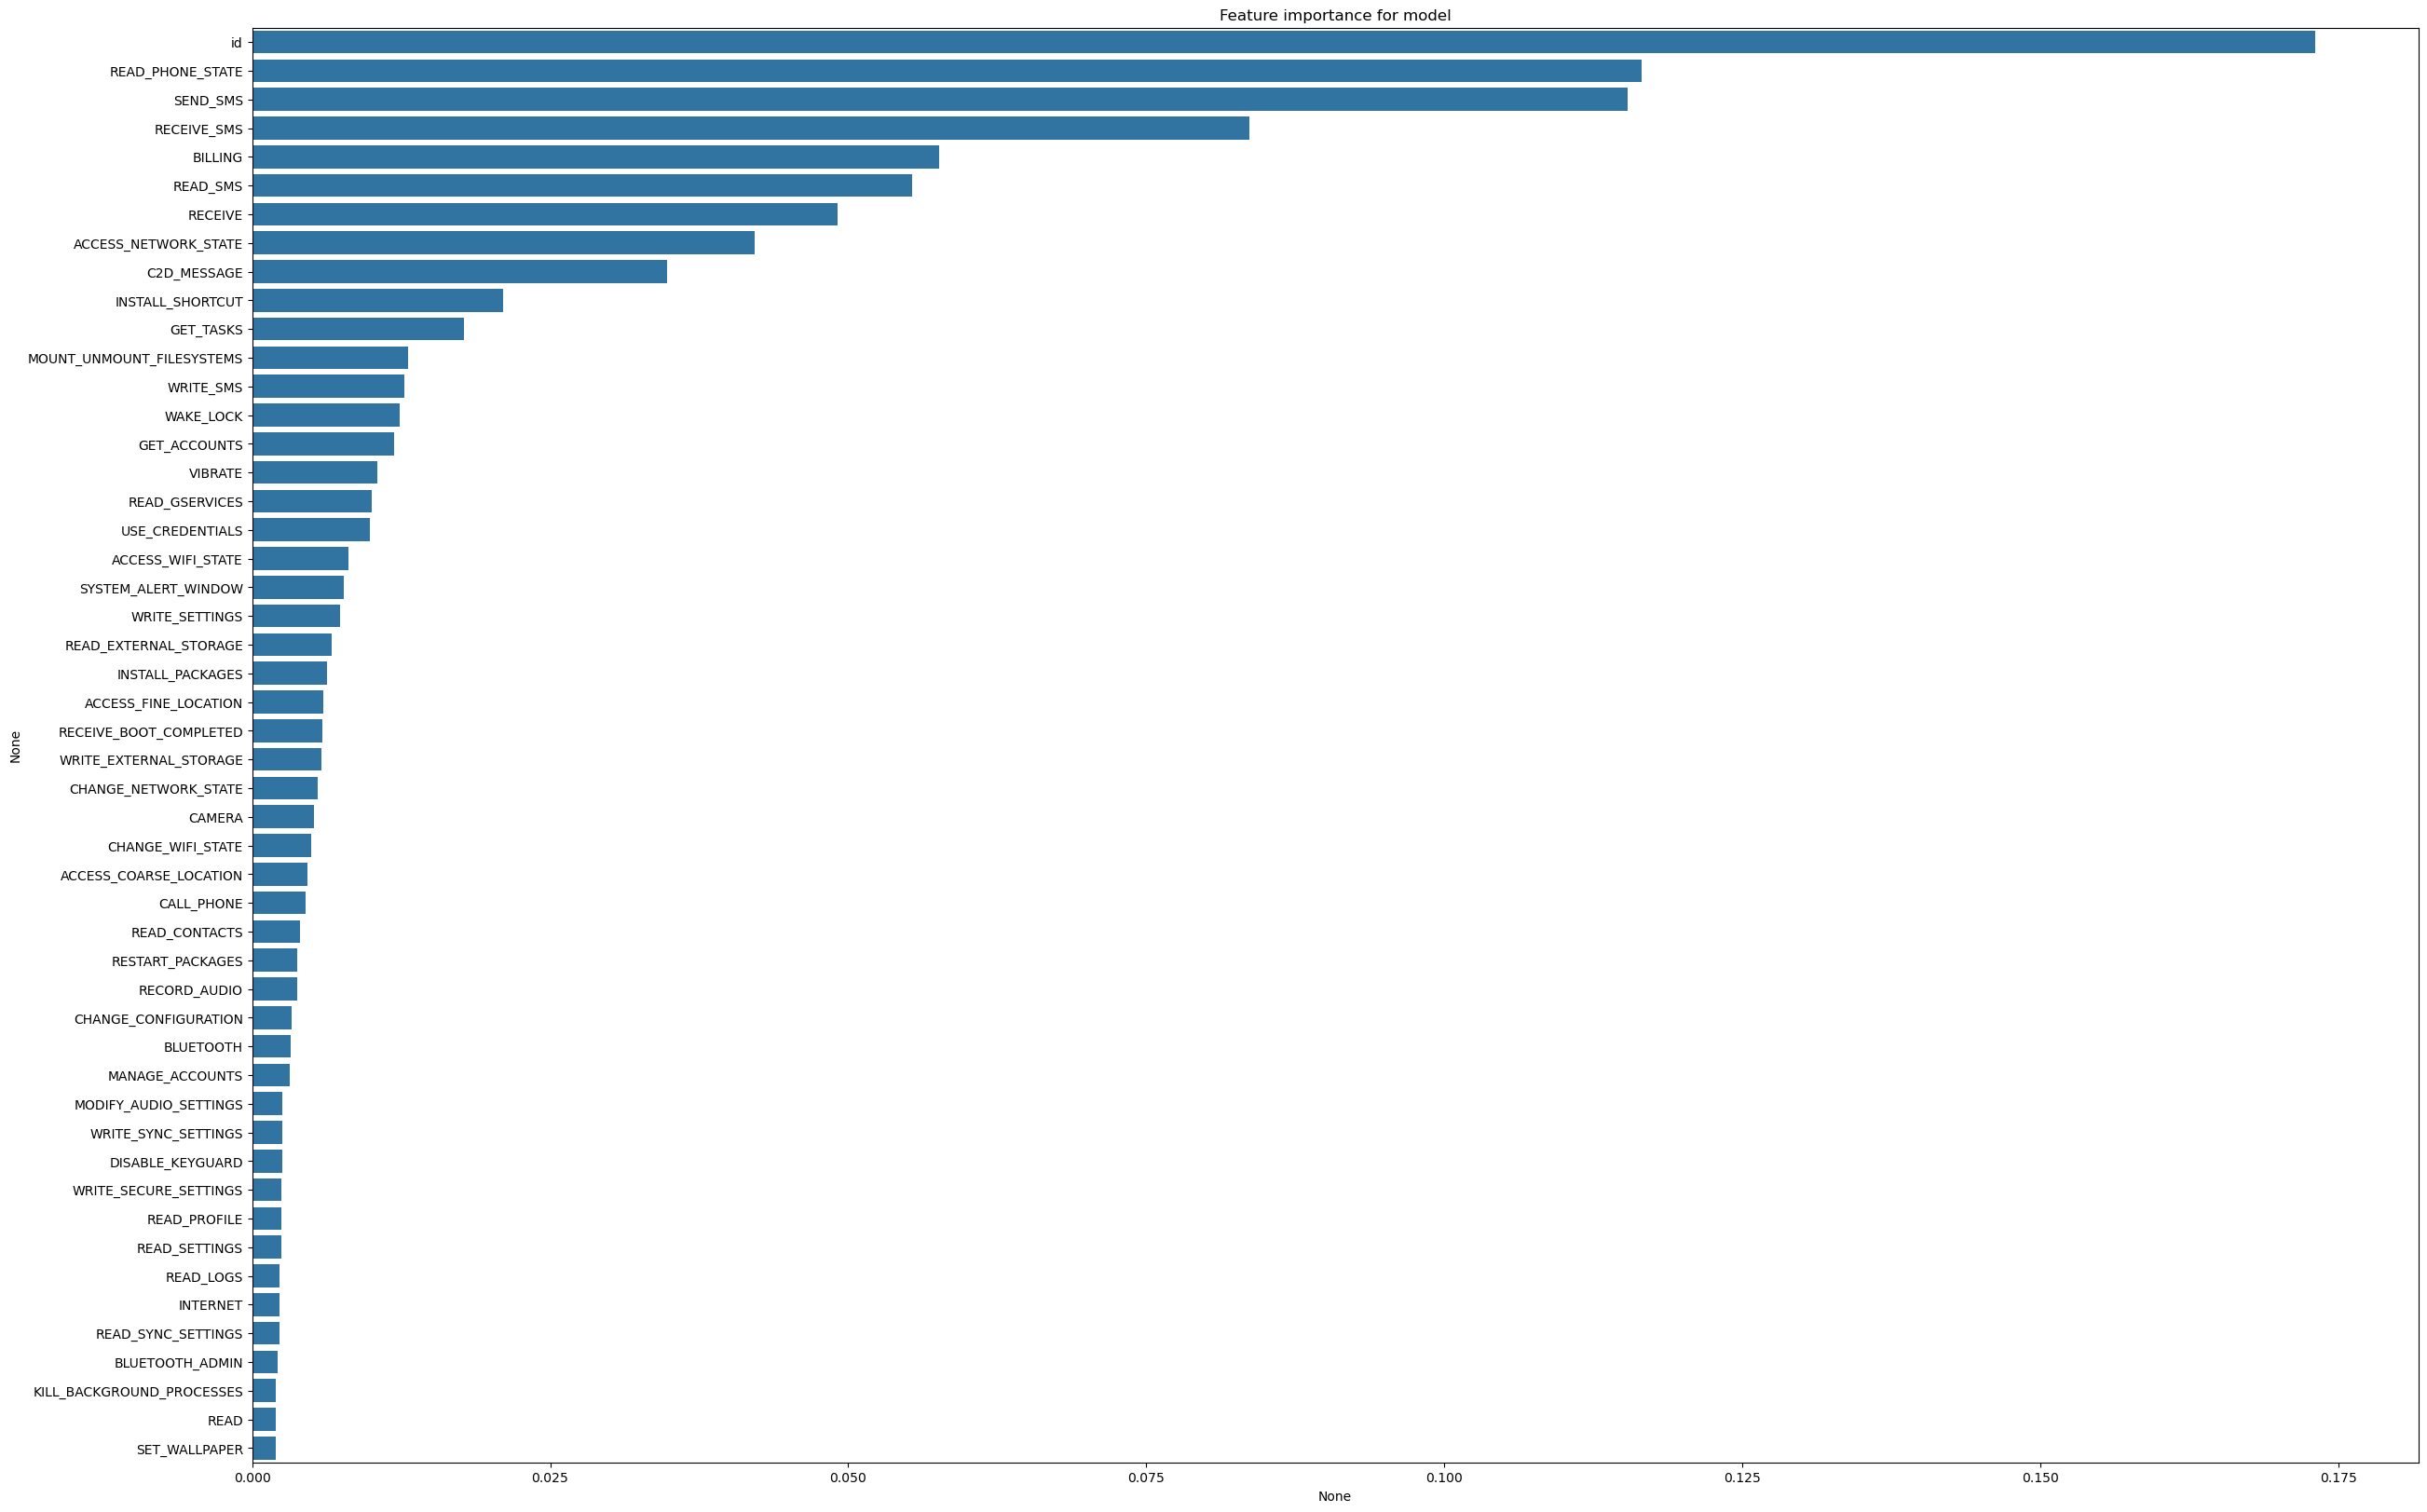

In [10]:
import matplotlib.pyplot as plt # plotting
import seaborn as sns # visualisation

feature_imp = pd.Series(CV.best_estimator_.feature_importances_,index=CV.best_estimator_.feature_names_in_).sort_values(ascending=False)
f,ax = plt.subplots(figsize=(30,20))
ax = sns.barplot(x=feature_imp[:50], y=feature_imp[:50].index)
ax.set_title('Feature importance for model')
plt.show()

### prediction finale

In [12]:
prediction = predTest['Malicious']
submitData = pd.read_csv('test.csv')
output = pd.DataFrame({'id': submitData.id, 
                       'Malicious': prediction})
output['Malicious'] = output['Malicious'].map({0:False, 1:True})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")
output.head(5)

Your submission was successfully saved!


,id,Malicious
0,6090,False
1,16279,True
2,4416,False
3,15152,True
4,13377,False
